# Evolution of Rap - Part 2
### *Using Machine Learning to Predict Top Rap Tracks*

## 1. Background

I will be using the same data pulled from Part 1 for this analysis. See Part 1 for details on how this dataset was created. After combining data from Billboard, Spotify, and Genius, I chose to focus on two questions:
1. How has rap changed over the years? Can I represent this visually?
2. Is it possible to accurately predict which tracks will break into the top 5 spots on Billboard? Do top 5 rap songs across all years share any similarities? 

This notebook will focus on the second question above.

**The analysis resulted in the following conclusions:**
1. Random forest was the best model but still had trouble predicting a track correctly as "Top 5". This suggests that top 5 tracks are very diverse on an audio feature basis.
2. Features derived from the actual lyrics will likely be needed to improve model performance (common words, bigrams, and trigrams).

## 2. Data Preparation

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

complete_df_3 = pd.read_pickle("complete_3.pkl")

In [36]:
complete_df_3["week"] = pd.to_datetime(complete_df_3["week"])

In [37]:
data_df = complete_df_3.groupby(by=["artist","title"], as_index=False).apply(lambda x : x[x["current_rank"]==(x["current_rank"].min())])
data_df = data_df.sort_values(by=["week","current_rank"],ascending=[False,True])

In [38]:
data_df

,,artist,current_rank,peak_pos,title,week,weeks_on_chart,duration_ms,explicit,spotify_popularity,year,...,acousticness,valence,processed_lyrics,era,mean_sentiment,std_sentiment,duration_sec,word_count,words_per_second,unique_word_proportion
402,0,Cardi B Featuring Megan Thee Stallion,1,1,WAP,2020-09-05,3,187541.0,True,100.0,2020,...,0.01940,0.357,"[puta, en, esta, casa, hay, alguna, puta, en, ...",Trap/Mumble Era (2015-Present),-0.020066,0.103138,187.541,698,3.721853,0.402579
791,1,Drake Featuring Lil Durk,2,2,Laugh Now Cry Later,2020-09-05,2,261492.0,True,96.0,2020,...,0.24400,0.522,"[woah, woah, yeah, sometim, we, laugh, and, so...",Trap/Mumble Era (2015-Present),-0.055024,0.333150,261.492,602,2.302174,0.338870
22,4,24kGoldn Featuring iann dior,5,5,Mood,2020-09-05,2,140525.0,True,96.0,2020,...,0.22100,0.756,"[ohohoh, yeah, yeah, yeah, yeah, yeah, whi, yo...",Trap/Mumble Era (2015-Present),0.198549,0.348027,140.525,426,3.031489,0.295775
2462,12,Saweetie,13,13,Tap In,2020-09-05,5,139413.0,True,87.0,2020,...,0.00576,0.432,"[dont, ever, stop, if, you, want, to, be, on, ...",Trap/Mumble Era (2015-Present),-0.116385,0.368274,139.413,415,2.976767,0.445783
1989,22,Money Man Featuring Lil Baby,23,23,24,2020-09-05,2,182857.0,True,80.0,2020,...,0.14600,0.459,"[yo, nflate, spice, that, bitch, up, burnin, o...",Trap/Mumble Era (2015-Present),-0.027759,0.337909,182.857,741,4.052347,0.453441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,38302,Boogie Down Productions,3,3,Jack Of Spades,1989-03-11,1,289373.0,False,28.0,1989,...,0.01270,0.568,"[again, we, start, let, me, say, my, part, abo...",Golden Era (1989-1997),-0.032921,0.317302,289.373,554,1.914484,0.460289
406,38308,Cash Money & Marvelous,11,11,Find An Ugly Woman,1989-03-11,1,204226.0,True,12.0,1989,...,0.00261,0.880,"[tictoc, toctic, tictoc, you, dont, stop, you,...",Golden Era (1989-1997),0.027437,0.371938,204.226,481,2.355234,0.388773
902,38310,Eric B. & Rakim,14,14,The R,1989-03-11,1,262800.0,False,60.0,1989,...,0.00556,0.809,"[whoever, underestim, still, wait, pumpin, the...",Golden Era (1989-1997),0.038239,0.194063,262.800,458,1.742770,0.379913
1502,38314,Kid 'N Play,24,24,Gittin' Funky,1989-03-11,1,284040.0,False,34.0,1989,...,0.01930,0.432,"[come, on, come, on, babi, yeah, kid, the, ing...",Golden Era (1989-1997),0.052888,0.281358,284.040,542,1.908182,0.464945


In [39]:
#Drop duplicate track rows, keeping only the first occurrence of when the track reached its top spot on the charts
data_df = data_df.drop_duplicates(subset=["artist","title"],keep="last").reset_index(drop=True)

In [40]:
#Target column: 1 if it peaked in the top 5 else 0
data_df["top_5"] = data_df["peak_pos"].apply(lambda x : 1 if x<=5 else 0)

In [41]:
data_df["top_5"].value_counts()

0    2289
1     796
Name: top_5, dtype: int64

## 3. Predictive Modeling
### 3.1. Data Split, Scaling, and SMOTE-NC
Next, it was time to build some machine learning models. I used the macro-F1 score to compare models. First, I filtered the columns I wanted to use as features into variable **X** and set the target variable to **y**. I used a stratified split into a train and test set. Then I split the train set into 5 stratified folds for cross-validation.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [43]:
X = data_df[["explicit", "danceability","energy","loudness","speechiness","acousticness","valence",
             "mean_sentiment","std_sentiment","duration_sec","words_per_second","unique_word_proportion"]]
X["explicit"] = X["explicit"].astype("category")
y = data_df["top_5"]

C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

In [45]:
from sklearn.preprocessing import StandardScaler

#We will scale all non-binary columns
scaler = StandardScaler()

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled.loc[:,X_train_scaled.columns!="explicit"] = scaler.fit_transform(X_train_scaled.loc[:,X_train_scaled.columns!="explicit"])
col_mean = scaler.mean_
col_std = (scaler.var_)**.5

X_test_scaled.loc[:,X_train_scaled.columns!="explicit"] = (X_test.loc[:,X_train_scaled.columns!="explicit"]-col_mean)/col_std

C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Next, I used the synthetic minority oversampling technique (SMOTE) which required installation of the following [module](https://pypi.org/project/imbalanced-learn/):

```pip install imbalanced-learn```

This technique generates additional samples from the non-majority classes so that the resulting data set has an equal representation for all classes. These additional samples are not simply copies of existing rows. Instead, the algorithm utilizes a nearest neighbors approach to synthesize new data points.

A major challenge that arose was how to incorporate SMOTE into grid search and cross-fold validation. The synthetically generated training samples depend on the original training set. As a result, my decision to use 5 stratified folds essentially meant that 5 different SMOTE generated training sets would be needed. The below code solves this issue by generating a SMOTE training set for each of the 5 folds and saving the corresponding SMOTE training vs cross-validation indices into the **cv_indices** list.

In [46]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=[0], random_state= 17)

X_train_custom = X_train_scaled.reset_index(drop=True)
y_train_custom = y_train.reset_index(drop=True)
num_rows_original = X_train_custom.shape[0]

smote_indices = []
cv_indices = []

fold_num=0
for train_index, cv_index in kf.split(X_train_custom,y_train_custom):
    num_rows_fold_original = len(train_index)
    X_train_smote_fold, y_train_smote_fold = sm.fit_sample(X_train_custom.iloc[train_index], 
                                                           y_train_custom.iloc[train_index])
    X_train_smote_fold = X_train_smote_fold.iloc[num_rows_fold_original:]
    y_train_smote_fold = y_train_smote_fold.iloc[num_rows_fold_original:]
    X_train_custom = pd.concat([X_train_custom,X_train_smote_fold],ignore_index=True)
    y_train_custom = pd.concat([y_train_custom,y_train_smote_fold],ignore_index=True)
    if fold_num==0:
        smote_indices.append([*range(num_rows_original,num_rows_original+X_train_smote_fold.shape[0])])
    else:
        last_row = smote_indices[-1][-1]
        smote_indices.append([*range(last_row+1,last_row+1+X_train_smote_fold.shape[0])])
    
    
    train_index_fold = np.append(train_index,smote_indices[fold_num])
    cv_index_fold = cv_index
    cv_indices.append((train_index_fold,cv_index_fold)) 
    
    fold_num+=1

Finally, I ran SMOTE on the entire training set (without leaving any data out for cross-validation).

In [47]:
X_train_smote, y_train_smote = sm.fit_sample(X_train_scaled, y_train)
y_train_smote.value_counts()

1    1831
0    1831
Name: top_5, dtype: int64

### 3.2. Logistic Regression

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_params = {"penalty":["l1","l2"], 
              "C":[.0001,.001,.01,.1,1,10,100,1000,3333,10000,33333,100000], 
              "random_state":[20],
              "solver":["liblinear"], 
              "max_iter":[1000]}
log = LogisticRegression()
log_grid = GridSearchCV(estimator=log,
                        param_grid=log_params,
                        scoring="f1_macro",
                        cv=cv_indices)
log_grid.fit(X_train_custom, y_train_custom)

GridSearchCV(cv=[(array([   0,    1,    3, ..., 3421, 3422, 3423]),
                  array([   2,    4,   10,   15,   16,   17,   18,   20,   21,   40,   43,
         50,   54,   58,   59,   64,   69,   74,   80,   84,   87,   90,
         96,   98,  104,  112,  116,  119,  121,  130,  131,  144,  146,
        152,  155,  157,  158,  162,  164,  167,  168,  171,  183,  184,
        191,  195,  198,  199,  209,  214,  217,  220,  223,  226,  230,
        235,  237,  238,  240,  246,  247,  250,  251,  254,  257,  263,
        264,  267,  269,  270,  288,  295,  309,  310,  311,  315,  319,
        320,  321,  3...
       2309, 2310, 2320, 2322, 2325, 2338, 2346, 2349, 2357, 2361, 2363,
       2365, 2370, 2375, 2377, 2383, 2384, 2388, 2389, 2395, 2397, 2400,
       2403, 2406, 2407, 2419, 2430, 2432, 2442, 2446, 2457]))],
             estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 3333,
                               10000, 333

In [50]:
log_grid.best_params_

{'C': 0.01,
 'max_iter': 1000,
 'penalty': 'l2',
 'random_state': 20,
 'solver': 'liblinear'}

In [51]:
log_grid.best_score_

0.5561362658267924

### 3.3. K-Nearest Neighbors
While the above logistic regression was quite promising, I wanted to see if other ML models would result in better performance. I next built a KNN model. Given that I did not have that many features, I used all of them for this analysis.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn_params = {"n_neighbors" : [2,4,8,16,32,64,128,256,512,1024],
              "weights" : ["uniform", "distance"],
              "p" : [1,2]}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(estimator=knn,
                        param_grid=knn_params,
                        scoring="f1_macro",
                        cv=cv_indices)
knn_grid.fit(X_train_custom[log_features], y_train_custom)

GridSearchCV(cv=[(array([   0,    1,    3, ..., 3421, 3422, 3423]),
                  array([   2,    4,   10,   15,   16,   17,   18,   20,   21,   40,   43,
         50,   54,   58,   59,   64,   69,   74,   80,   84,   87,   90,
         96,   98,  104,  112,  116,  119,  121,  130,  131,  144,  146,
        152,  155,  157,  158,  162,  164,  167,  168,  171,  183,  184,
        191,  195,  198,  199,  209,  214,  217,  220,  223,  226,  230,
        235,  237,  238,  240,  246,  247,  250,  251,  254,  257,  263,
        264,  267,  269,  270,  288,  295,  309,  310,  311,  315,  319,
        320,  321,  3...
       2280, 2283, 2286, 2287, 2288, 2296, 2299, 2301, 2303, 2307, 2308,
       2309, 2310, 2320, 2322, 2325, 2338, 2346, 2349, 2357, 2361, 2363,
       2365, 2370, 2375, 2377, 2383, 2384, 2388, 2389, 2395, 2397, 2400,
       2403, 2406, 2407, 2419, 2430, 2432, 2442, 2446, 2457]))],
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 4, 

In [60]:
knn_grid.best_params_

{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}

In [61]:
knn_grid.best_score_

0.530958495897352

### 3.4. Support Vector Machine


In [62]:
from sklearn.svm import SVC
svm_params = {"C":[.0001,.001,.01,.1,1,10,100,1000], 
              "kernel":["poly","rbf"],
              "degree":[2,3]}
svm = SVC()
svm_grid = GridSearchCV(estimator=svm,
                        param_grid=svm_params,
                        scoring="f1_macro",
                        cv=cv_indices, 
                        verbose=3)
svm_grid.fit(X_train_custom, y_train_custom)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=0.0001, degree=2, kernel=poly .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.224, total=   0.6s
[CV] C=0.0001, degree=2, kernel=poly .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.205, total=   0.5s
[CV] C=0.0001, degree=2, kernel=poly .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.426, total=   0.6s
[CV] C=0.0001, degree=2, kernel=poly .................................
[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.205, total=   0.8s
[CV] C=0.0001, degree=2, kernel=poly .................................
[CV] ..... C=0.0001, degree=2, kernel=poly, score=0.205, total=   0.5s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.570, total=   0.8s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.550, total=   0.7s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.574, total=   0.8s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] ...... C=0.0001, degree=2, kernel=rbf, score=0.561, total=   0.9s
[CV] C=0.0001, degree=2, kernel=rbf ..................................
[CV] .

[CV] ........ C=0.1, degree=2, kernel=poly, score=0.472, total=   0.4s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.501, total=   0.5s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.532, total=   0.5s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.466, total=   0.5s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV] ........ C=0.1, degree=2, kernel=poly, score=0.510, total=   0.5s
[CV] C=0.1, degree=2, kernel=rbf .....................................
[CV] ......... C=0.1, degree=2, kernel=rbf, score=0.543, total=   0.7s
[CV] C=0.1, degree=2, kernel=rbf .....................................
[CV] ......... C=0.1, degree=2, kernel=rbf, score=0.557, total=   0.8s
[CV] C=0.1, degree=2, kernel=rbf .....................................
[CV] .

[CV] .......... C=10, degree=3, kernel=rbf, score=0.522, total=   1.4s
[CV] C=10, degree=3, kernel=rbf ......................................
[CV] .......... C=10, degree=3, kernel=rbf, score=0.535, total=   1.1s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.505, total=   4.6s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.509, total=   3.6s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.562, total=   5.3s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.499, total=   4.4s
[CV] C=100, degree=2, kernel=poly ....................................
[CV] ........ C=100, degree=2, kernel=poly, score=0.537, total=   4.3s
[CV] C=100, degree=2, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 22.3min finished


GridSearchCV(cv=[(array([   0,    1,    3, ..., 3421, 3422, 3423]),
                  array([   2,    4,   10,   15,   16,   17,   18,   20,   21,   40,   43,
         50,   54,   58,   59,   64,   69,   74,   80,   84,   87,   90,
         96,   98,  104,  112,  116,  119,  121,  130,  131,  144,  146,
        152,  155,  157,  158,  162,  164,  167,  168,  171,  183,  184,
        191,  195,  198,  199,  209,  214,  217,  220,  223,  226,  230,
        235,  237,  238,  240,  246,  247,  250,  251,  254,  257,  263,
        264,  267,  269,  270,  288,  295,  309,  310,  311,  315,  319,
        320,  321,  3...
       2280, 2283, 2286, 2287, 2288, 2296, 2299, 2301, 2303, 2307, 2308,
       2309, 2310, 2320, 2322, 2325, 2338, 2346, 2349, 2357, 2361, 2363,
       2365, 2370, 2375, 2377, 2383, 2384, 2388, 2389, 2395, 2397, 2400,
       2403, 2406, 2407, 2419, 2430, 2432, 2442, 2446, 2457]))],
             estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 

In [63]:
svm_grid.best_params_

{'C': 0.1, 'degree': 2, 'kernel': 'rbf'}

In [64]:
svm_grid.best_score_

0.5590538164185677

### 3.5. Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf_params = {"n_estimators" : [100], 
             "max_depth" : [2,4,8,16,32,64,128,None], 
             "max_features" : ["sqrt", "log2", .1, .25, .5, 5, 10, 25], 
             "min_samples_leaf" : [1,3,5],
             "random_state" : [10]}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf,
                       param_grid=rf_params,
                       scoring="f1_macro",
                       cv=cv_indices, 
                       verbose=3)
rf_grid.fit(X_train_custom, y_train_custom)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.517, total=   0.6s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.550, total=   0.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.532, total=   0.6s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.473, total=   0.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.519, total=   1.2s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.517, total=   1.0s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.550, total=   0.7s
[CV] max_depth=2, max_features=s

[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.547, total=   0.5s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.558, total=   0.5s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.488, total=   0.6s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.533, total=   0.5s
[CV] max_depth=2, max_features=0.25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=0.25, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.517, total=   0.8s
[CV] max_depth=2, max_features=0.25, mi

[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.509, total=   0.9s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.517, total=   0.8s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.532, total=   1.1s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.459, total=   0.9s
[CV] max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.498, total=   0.8s
[CV] max_depth=2, max_features=5, min_samples_leaf=5, n_est

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=2, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=2, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=2, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=2, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.528, total=   0.8s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.562, total=   1.0s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.544, total=   0.8s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.504, total=   1.1s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.517, total=   1.0s
[CV] max_depth=4, max_features=s

[CV]  max_depth=4, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.533, total=   1.1s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.536, total=   0.6s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.545, total=   0.8s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.579, total=   0.7s
[CV] max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.509, total=   0.6s
[CV] max_depth=4, max_features=0.1, min_s

[CV]  max_depth=4, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.487, total=   1.2s
[CV] max_depth=4, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.503, total=   1.3s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.535, total=   1.4s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.548, total=   1.6s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.559, total=   1.4s
[CV] max_depth=4, max_features=5, min_samples_leaf=3, n_est

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.3s
[CV] max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.3s
[CV] max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.3s
[CV] max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=4, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.550, total=   1.3s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.564, total=   1.3s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.578, total=   1.2s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.511, total=   1.5s
[CV] max_depth=8, max_features=sqrt,

[CV]  max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.517, total=   0.9s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.512, total=   0.8s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.547, total=   1.1s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.549, total=   0.7s
[CV] max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.585, total=   0.7s
[CV] max_depth=8, max_features=0.1, min_s

[CV]  max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.564, total=   1.9s
[CV] max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.506, total=   1.9s
[CV] max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.548, total=   1.7s
[CV] max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.555, total=   1.9s
[CV] max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.564, total=   2.0s
[CV] max_depth=8, max_features=5, min_samples_leaf=3, n_est

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=8, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=8, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=8, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=8, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.547, total=   2.0s
[CV] max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.575, total=   1.6s
[CV] max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.568, total=   1.7s
[CV] max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.521, total=   1.8s
[CV] max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.526, total=   1.7s
[CV] max_depth=16, max_

[CV]  max_depth=16, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.498, total=   0.9s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.564, total=   0.9s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.553, total=   1.0s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.621, total=   0.9s
[CV] max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.545, total=   0.9s
[CV] max_depth=16, max_features=

[CV]  max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.527, total=   2.4s
[CV] max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.538, total=   2.4s
[CV] max_depth=16, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.571, total=   2.7s
[CV] max_depth=16, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.566, total=   2.3s
[CV] max_depth=16, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.608, total=   2.7s
[CV] max_depth=16, max_features=5, min_samples_lea

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=16, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.542, total=   1.7s
[CV] max_depth=32, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.560, total=   1.6s
[CV] max_depth=32, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.582, total=   1.8s
[CV] max_depth=32, max_features=s

[CV]  max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.620, total=   0.9s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.546, total=   0.9s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.488, total=   0.9s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.575, total=   0.8s
[CV] max_depth=32, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.545, total=   0.8s
[CV] max_depth=32, max_features=

[CV]  max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.548, total=   3.3s
[CV] max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.599, total=   3.3s
[CV] max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.515, total=   3.1s
[CV] max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.532, total=   3.6s
[CV] max_depth=32, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.545, total=   3.1s
[CV] max_depth=32, max_features=5, min_samples_lea

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=32, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=32, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=32, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.2s

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco


[CV] max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=32, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.544, total=   1.8s
[CV] max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.561, total=   1.6s
[CV] max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.581, total=   1.7s
[CV] max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.504, total=   1.8s
[CV] max_depth=64, max_feat

[CV]  max_depth=64, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.547, total=   0.9s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.488, total=   0.8s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.575, total=   1.0s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.545, total=   0.8s
[CV] max_depth=64, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.601, total=   0.8s
[CV] max_depth=64, max_features=

[CV]  max_depth=64, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.601, total=   2.5s
[CV] max_depth=64, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.515, total=   2.5s
[CV] max_depth=64, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.526, total=   2.5s
[CV] max_depth=64, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.544, total=   2.3s
[CV] max_depth=64, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.562, total=   2.2s
[CV] max_depth=64, max_features=5, min_samples_lea

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=64, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=64, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=64, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=64, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.544, total=   1.8s
[CV] max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.561, total=   1.6s
[CV] max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.581, total=   1.7s
[CV] max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.504, total=   1.7s
[CV] max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.522, total=   1.7s
[CV] max_depth

[CV]  max_depth=128, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.488, total=   0.9s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.575, total=   0.8s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.545, total=   0.8s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.601, total=   1.0s
[CV] max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.526, total=   1.0s
[CV] max_depth=128, max

[CV]  max_depth=128, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.515, total=   2.8s
[CV] max_depth=128, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.526, total=   2.8s
[CV] max_depth=128, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.544, total=   3.5s
[CV] max_depth=128, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.562, total=   2.8s
[CV] max_depth=128, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=5, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.591, total=   2.7s
[CV] max_depth=128, max_features=5, min_s

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco


[CV]  max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.2s
[CV] max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=128, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.544, total=   2.1s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.561, total=   2.0s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.581, total=   1.7s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.504, total=   2.1s
[CV] max_d

[CV]  max_depth=None, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.620, total=   1.0s
[CV] max_depth=None, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.547, total=   1.2s
[CV] max_depth=None, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=0.1, min_samples_leaf=3, n_estimators=100, random_state=10, score=0.488, total=   0.9s
[CV] max_depth=None, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.575, total=   1.0s
[CV] max_depth=None, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=0.1, min_samples_leaf=5, n_estimators=100, random_state=10, score=0.545, total=   0.8s
[CV] max_depth

[CV]  max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.553, total=   2.6s
[CV] max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.548, total=   2.3s
[CV] max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.601, total=   2.4s
[CV] max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.515, total=   2.7s
[CV] max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=5, min_samples_leaf=1, n_estimators=100, random_state=10, score=0.526, total=   2.4s
[CV] max_depth=None, max_feature

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=1, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=None, max_features=25, min_samples_leaf=3, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

[CV]  max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s
[CV] max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10 
[CV]  max_depth=None, max_features=25, min_samples_leaf=5, n_estimators=100, random_state=10, score=nan, total=   0.1s


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 1004, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sahil\anaconda3\lib\site-packages\joblib\parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sahil\anaco

GridSearchCV(cv=[(array([   0,    1,    3, ..., 3421, 3422, 3423]),
                  array([   2,    4,   10,   15,   16,   17,   18,   20,   21,   40,   43,
         50,   54,   58,   59,   64,   69,   74,   80,   84,   87,   90,
         96,   98,  104,  112,  116,  119,  121,  130,  131,  144,  146,
        152,  155,  157,  158,  162,  164,  167,  168,  171,  183,  184,
        191,  195,  198,  199,  209,  214,  217,  220,  223,  226,  230,
        235,  237,  238,  240,  246,  247,  250,  251,  254,  257,  263,
        264,  267,  269,  270,  288,  295,  309,  310,  311,  315,  319,
        320,  321,  3...
       2309, 2310, 2320, 2322, 2325, 2338, 2346, 2349, 2357, 2361, 2363,
       2365, 2370, 2375, 2377, 2383, 2384, 2388, 2389, 2395, 2397, 2400,
       2403, 2406, 2407, 2419, 2430, 2432, 2442, 2446, 2457]))],
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, None],
                         'max_features': ['sqr

In [66]:
rf_grid.best_params_

{'max_depth': 16,
 'max_features': 0.1,
 'min_samples_leaf': 5,
 'n_estimators': 100,
 'random_state': 10}

In [67]:
rf_grid.best_score_

0.5615439525222539

### 3.6. Model Selection and Interpretation

The results of the above models are summarized in the table below (ordered from best to worst performance):

In [68]:
models = ["Logistic Regression", 
          "K-Nearest Neighbors",
          "Support Vector Machine",
          "Random Forest"]

optimized_parameters = [log_grid.best_params_, 
                        knn_grid.best_params_,  
                        svm_grid.best_params_,
                        rf_grid.best_params_]

F1 = [log_grid.best_score_,
      knn_grid.best_score_,
      svm_grid.best_score_,
      rf_grid.best_score_]
       
model_df = pd.DataFrame({"model" : models, 
                         "optimized_parameters" : optimized_parameters, 
                         "macro-F1" : F1})

with pd.option_context('display.max_colwidth', 150):
    display(model_df.sort_values(by="macro-F1",ascending=False))

,model,optimized_parameters,macro-F1
3,Random Forest,"{'max_depth': 16, 'max_features': 0.1, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 10}",0.561544
2,Support Vector Machine,"{'C': 0.1, 'degree': 2, 'kernel': 'rbf'}",0.559054
0,Logistic Regression,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 20, 'solver': 'liblinear'}",0.556136
1,K-Nearest Neighbors,"{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}",0.530958


The random forest model performed the best, although the macro-F1 score was quite similar across models. I ran the random forest model with the optimized parameters on the test set for a final assessment of macro-F1.

In [69]:
#Fit model to entire SMOTE training set
model_best = RandomForestClassifier(max_depth=16,max_features=.1,min_samples_leaf=5,n_estimators=100,random_state=10)
model_best.fit(X_train_smote,y_train_smote)

#Predict test values
y_pred = model_best.predict(X_test)

#Calculate weighted-F1
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,average="macro")

0.5634600022823233

Next, I built a confusion matrix. The model clearly had trouble correctly predicting "Top 5". 

[Text(0, 0.5, 'Not Top 5'), Text(0, 1.5, 'Top 5')]

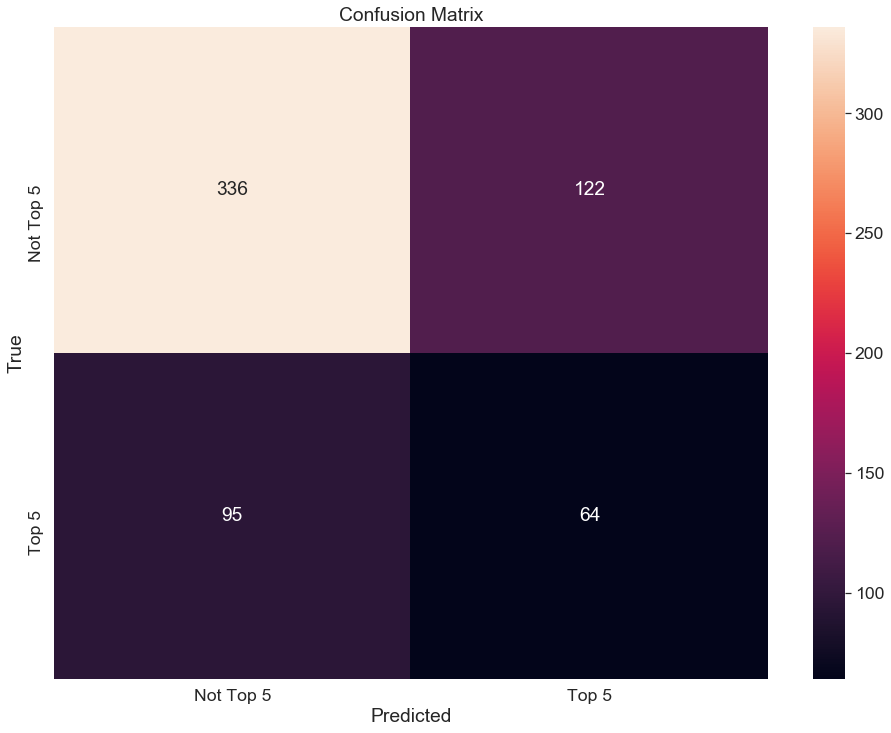

In [70]:
from sklearn.metrics import confusion_matrix
sns.set(font_scale=1.6)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(cm, annot=True, ax = ax, fmt="d")
ax.set_xlabel('Predicted')
ax.set_ylabel('True') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Not Top 5", "Top 5"])
ax.yaxis.set_ticklabels(["Not Top 5", "Top 5"])

## 4. Conclusion/Further Steps

The chosen random forest model had trouble identifying Top 5 tracks. It is very possible that the features I chose are not adequate to make accurate predictions, as Top 5 tracks are very diverse. 

As a first additional step, I would conduct error analysis by randomly choosing some misclassified tracks. If a pattern was evident as to why tracks were consistently misclassified, I could adjust the model/add more complicated features to improve it. Second, I would include additional features extracted from the actual lyrics of the tracks. Perhaps the presence of certain words, bigrams, or trigrams would aid in prediction. I also suspect that non-musical features, such as marketing budget, general popularity of the artist, etc. have a significant influence of which tracks break into the top spots.